In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [4]:
#Load the dataset
data = pd.read_excel('clean_data.xlsx')

In [5]:
#Display the dataset
data.head()

,make,model,trim,body,transmission,state,condition,odometer,color,interior,seller,mmr,sellingprice,Age
0,BMW,3 Series,328i SULEV,Sedan,1,ca,45,1331,gray,black,financial services remarketing (lease),31900,30000,1
1,Volvo,S60,T5,Sedan,1,ca,41,14282,white,black,volvo na rep/world omni,27500,27750,0
2,Chevrolet,Cruze,1LT,Sedan,1,ca,2,28617,black,black,enterprise vehicle exchange / tra / rental / t...,11900,9800,0
3,Audi,A4,2.0T Premium Plus quattro,Sedan,1,ca,42,9557,white,black,audi mission viejo,32100,32250,0
4,Chevrolet,Camaro,LT,Convertible,1,ca,3,4809,red,black,d/m auto sales inc,26300,17500,1


In [6]:
#Convert data to a DataFrame
df = pd.DataFrame(data)

In [7]:
df_ori= df.drop(columns=['sellingprice'])
df_new = df['sellingprice']

#Move the label column to the last column
df = pd.concat([df_ori, df_new], axis=1)

print(df.head())

        make     model                       trim         body  transmission  \
0        BMW  3 Series                 328i SULEV        Sedan             1   
1      Volvo       S60                         T5        Sedan             1   
2  Chevrolet     Cruze                        1LT        Sedan             1   
3       Audi        A4  2.0T Premium Plus quattro        Sedan             1   
4  Chevrolet    Camaro                         LT  Convertible             1   

  state  condition  odometer  color interior  \
0    ca         45      1331   gray    black   
1    ca         41     14282  white    black   
2    ca          2     28617  black    black   
3    ca         42      9557  white    black   
4    ca          3      4809    red    black   

                                              seller    mmr  Age  sellingprice  
0             financial services remarketing (lease)  31900    1         30000  
1                            volvo na rep/world omni  27500    0    

In [8]:
#Calculate the number of unique values
df.nunique()

make                45
model              716
trim              1408
body                80
transmission         2
state               38
condition           41
odometer        165767
color               20
interior            17
seller           12429
mmr                730
Age                 26
sellingprice      1113
dtype: int64

In [9]:
#Drop columns
df_droped = df.drop(['seller', 'model', 'trim', 'body'], axis=1)

In [10]:
#One-hot encoding
df_encoded = pd.get_dummies(df_droped, columns=['make',  'state', 'color', 'interior'])

df_encoded.shape[1]

126

In [11]:
# Calculate the number of samples for each category
class_counts = df_encoded['sellingprice'].value_counts()

# Calculate the imbalance ratio of classes
positive_samples = class_counts.iloc[1]  
negative_samples = class_counts.iloc[0]  
imbalance_ratio = positive_samples / negative_samples

print("Imbalance Ratio:", imbalance_ratio)


Imbalance Ratio: 0.9988484569322893


In [13]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X = df_encoded.drop(columns=['sellingprice']) 
y = df_encoded['sellingprice']

scaler = StandardScaler()
X_normalized = scaler.fit_transform(X)
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [88]:
from sklearn.ensemble import RandomForestRegressor

# Instantiate a random forest regression model
rf_regressor = RandomForestRegressor(random_state=42)

# Train the model on the training set
rf_regressor.fit(X_train, y_train)

# Predict on the test set
y_pred = rf_regressor.predict(X_test)

In [18]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

# Calculate the mean absolute error between predicted and actual values
mae = mean_absolute_error(y_test, y_pred)
print("Mean Absolute Error:", mae)
# Calculate the mean squared error between predicted and actual values
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error (MSE):", mse)

# Calculate the root mean squared error
rmse = np.sqrt(mse)
print("Root Mean Squared Error (RMSE):", rmse)

Mean Absolute Error: 881.3631575835753
Mean Squared Error (MSE): 1732084.3336044236
Root Mean Squared Error (RMSE): 1316.0867500299605
The R² value is: 0.9686877377426738


In [14]:
from sklearn.model_selection import GridSearchCV, train_test_split
import os

# Check if the file 'best_params.txt' already exists
if os.path.isfile('best_params.txt'):
    # If the file exists, load the best parameters from the file
    with open('best_params.txt', 'r') as f:
        best_params = eval(f.read())  # Read the contents of the file and convert it to a dictionary
    print("Best parameters found (loaded from file): ", best_params)
else:
    # If the file doesn't exist, perform grid search
    # Split 80% of the data as the training subset and 20% as the validation subset
    X_train_sub, _, y_train_sub, _ = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
    
    # Define the Random Forest model
    rf_model = RandomForestRegressor(random_state=42)
    
    # Define the parameter grid for tuning
    param_grid = {
        'n_estimators': [50, 100, 200],
        'max_depth': [None, 10],
        # You can add other parameters, such as min_samples_split, min_samples_leaf, max_features, etc.
    }
    
    # Create a GridSearchCV object
    grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
    
    # Perform grid search on the training subset
    grid_search.fit(X_train_sub, y_train_sub)
    
    # Output the best parameter combination
    print("Best parameters found: ", grid_search.best_params_)
    best_params = grid_search.best_params_
    
    # Save the best parameters to a file
    with open('best_params.txt', 'w') as f:
        f.write(str(best_params))

Best parameters found (loaded from file):  {'max_depth': None, 'n_estimators': 100}


In [16]:
from sklearn.ensemble import RandomForestRegressor
# Create a new random forest model with the best parameters obtained from grid search
best_rf_model = RandomForestRegressor(n_estimators=best_params['n_estimators'],
                                      max_depth=best_params['max_depth'],
                                      random_state=42)

# Train this new random forest model using the full training set
best_rf_model.fit(X_train, y_train)

# Predict on the test set
y_pred_test = best_rf_model.predict(X_test)

In [17]:
# Evaluate the model performance
from sklearn.metrics import mean_squared_error

mae = mean_absolute_error(y_test, y_pred_test)
print("Mean Absolute Error:", mae)

# Calculate the mean squared error between predicted and actual values
mse = mean_squared_error(y_test, y_pred_test)
print("Mean Squared Error (MSE):", mse)

# Calculate the root mean squared error
rmse = np.sqrt(mse)
print("Root Mean Squared Error (RMSE):", rmse)
from sklearn.metrics import r2_score

# y_test represents the true values, and y_pred_test represents the predicted values
r_squared = r2_score(y_test, y_pred_test)
print("The R² value is:", r_squared)

Mean Absolute Error: 881.3631575835753
Mean Squared Error (MSE): 1732084.3336044236
Root Mean Squared Error (RMSE): 1316.0867500299605
The R² value is: 0.9686877377426738


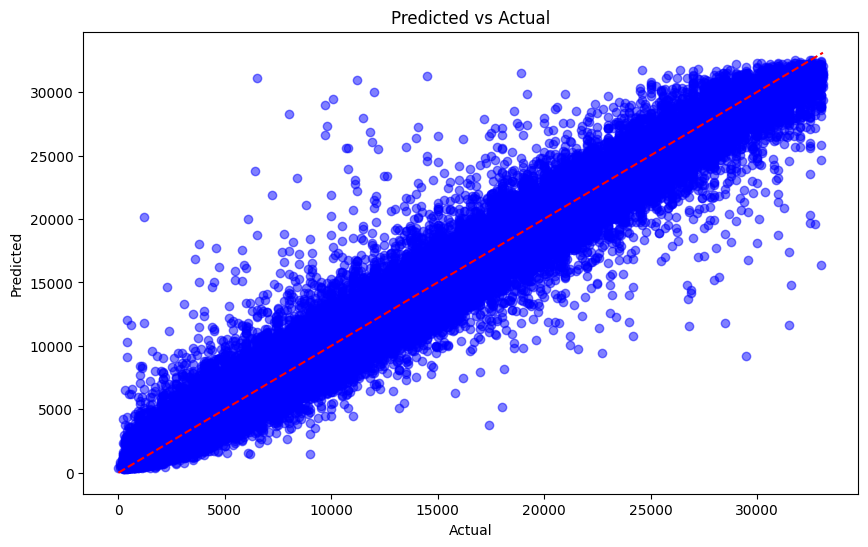

In [86]:
import matplotlib.pyplot as plt

y_test_list = y_test.tolist()
y_pred_test_list = y_pred_test.tolist()

#scatter
plt.figure(figsize=(10, 6))
plt.scatter(y_test_list, y_pred_test_list, color='blue', alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label='Actual')
plt.title('Predicted vs Actual')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.show()